In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337

set_seed(seed)

In [4]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [7]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [8]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [9]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.FIFTEEN_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

raw_df_filename = f'ocean_raw_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{today}.csv'
features_filename = f'ocean_features_{today}.npy'
emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_vol_{today}.csv'

In [10]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [95]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [96]:
symbols_df.to_csv(raw_df_filename, index=False)

In [9]:
symbols_df = pd.read_csv(raw_df_filename)
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [10]:
symbols_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume
0,10000000AIDOGEUSDT,2024-03-05 10:45:00,0.004816,0.004816,0.004807,0.004807,400.0
1,10000000AIDOGEUSDT,2024-03-05 11:00:00,0.004807,0.006305,0.004617,0.006210,719649408.0
2,10000000AIDOGEUSDT,2024-03-05 11:15:00,0.006210,0.007224,0.005910,0.006182,743186304.0
3,10000000AIDOGEUSDT,2024-03-05 11:30:00,0.006182,0.006208,0.005710,0.005939,321725888.0
4,10000000AIDOGEUSDT,2024-03-05 11:45:00,0.005939,0.006073,0.005634,0.005765,209583600.0


In [36]:
def volume_features(df, period_14=14, period_20=20):
    df = df.copy()

    df['Date'] = df['Timestamp'].dt.date

    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)

    df['ADV'] = df.groupby(['Symbol', 'Date'])['Volume'].transform('mean')

    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']

    df['Cum_Volume'] = df.groupby(['Symbol', 'Date'])['Volume'].cumsum()
    df['Cum_Price_Volume'] = df.groupby(['Symbol', 'Date'])['Cumulative Price * Volume'].cumsum()

    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume'].replace(0, 1e6)
    df['VWAP_MOM'] = df.groupby('Symbol')['VWAP'].diff()

    df['Midpoint Move'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 1e6) / (df['High'] - df['Low']).replace(0, 1e6)
    df['EOM'] = df['Midpoint Move'] / df['Box Ratio']
    df['EOM'] = df.groupby('Symbol')['EOM'].transform(lambda x: x.rolling(window=period_14).mean())

    df['Price Change'] = df.groupby(['Symbol', 'Date'])['Close'].diff()

    df['OBV_Sign'] = df['Price Change'].apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    df['OBV'] = (df['OBV_Sign'] * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e6)
    df['A/D'] = df.groupby(['Symbol', 'Date'])['A/D'].cumsum()

    df['CMF'] = df['A/D'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).sum())

    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = df.groupby(['Symbol', 'Date'])['Amihud_Illiquidity'].transform('mean')

    df['Liquidity_Ratio'] = df['Volume'] / df['Typical Price'].replace(0, 1e6)

    df['II'] = (2 * df['Close'] - df['High'] - df['Low']) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e6)

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']
    df['Price Diff'] = df.groupby(['Symbol', 'Date'])['Typical Price'].diff()
    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Diff'] < 0, 0)
    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum'].replace(0, 1e6)
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['TR1'] = df['High'] - df['Low']
    df['TR2'] = (df['High'] - df['Previous Close']).abs()
    df['TR3'] = (df['Low'] - df['Previous Close']).abs()
    df['True Range'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

    df['LII'] = df['Volume'] / (df['Typical Price'] * df['True Range']).replace(0, 1e6)

    df['HL'] = df['High'] - df['Low']

    df['Buy Volume'] = df['Volume'].where(df['Price Change'] > 0, 0)
    df['Sell Volume'] = df['Volume'].where(df['Price Change'] < 0, 0)
    df['Volume Delta'] = df['Buy Volume'] - df['Sell Volume']

    df['Volume_IMB'] = df.groupby('Symbol')['Volume Delta'].transform(lambda x: x.rolling(window=period_20).sum())
    df['Flow_R'] = df['Buy Volume'] / df['Sell Volume'].replace(0, 1e6)

    df['CVD'] = df['Buy Volume'] - df['Sell Volume']
    df['CVD'] = df.groupby('Symbol')['CVD'].cumsum()

    df['RVOL'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e6)

    df['KVO'] = (df['Volume'] * (2 * (df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])).ewm(span=period_14, adjust=False).mean().replace(0, 1e6)

    df['VROC'] = df['Volume'].pct_change(period_14)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    df.drop(columns=[
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume', 'Buy Volume', 'Sell Volume', 'Midpoint Move',
        'Price Change', 'OBV_Sign', 'Raw Money Flow', 'Price Diff', 'True Range', 'Money Flow Ratio', 'Volume Delta', 'Box Ratio',
        'Positive Money Flow', 'Negative Money Flow', 'Positive Money Flow Sum', 'Negative Money Flow Sum', 'Previous Close',  'TR1', 'TR2', 'TR3'
    ], inplace=True)

    return df

In [37]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [11]:
volume_df = pd.read_csv(volume_df_filename)

In [12]:
volume_df.shape[0]

8034150

In [13]:
volume_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume,ADV,VWAP,VWAP_MOM,...,II,MFI,LII,HL,Volume_IMB,Flow_R,CVD,RVOL,KVO,VROC
0,10000000AIDOGEUSDT,2024-03-05 10:45:00,0.004816,0.004816,0.004807,0.004807,400.0,213498380.0,0.004810,NaN,...,-2.500000e-03,NaN,9.240178e+09,0.000009,NaN,0.0000,0.0,NaN,-4.000000e+02,NaN
1,10000000AIDOGEUSDT,2024-03-05 11:00:00,0.004807,0.006305,0.004617,0.006210,719649400.0,213498380.0,0.005711,0.000901,...,1.233157e-09,NaN,7.465549e+13,0.001688,NaN,719.6494,719649400.0,NaN,1.757055e+08,NaN
2,10000000AIDOGEUSDT,2024-03-05 11:15:00,0.006210,0.007224,0.005910,0.006182,743186300.0,213498380.0,0.006081,0.000370,...,-7.884923e-10,NaN,8.784284e+13,0.001314,NaN,0.0000,-23536896.0,NaN,1.147229e+08,NaN
3,10000000AIDOGEUSDT,2024-03-05 11:30:00,0.006182,0.006208,0.005710,0.005939,321725900.0,213498380.0,0.006057,-0.000023,...,-2.496596e-10,NaN,1.085350e+14,0.000498,NaN,0.0000,-345262800.0,NaN,1.157066e+08,NaN
4,10000000AIDOGEUSDT,2024-03-05 11:45:00,0.005939,0.006073,0.005634,0.005765,209583600.0,213498380.0,0.006033,-0.000025,...,-1.923765e-09,NaN,8.197313e+13,0.000439,NaN,0.0000,-554846400.0,NaN,9.735090e+07,NaN


In [14]:
symbols = volume_df['Symbol'].unique()
n_symbols = len(symbols)

print("N Symbols: ", n_symbols)

N Symbols:  411


In [15]:
volume = ['ADV', 'RVOL', 'Volume_IMB', 'CVD', 'VROC']
price_volume = ['VWAP', 'VWAP_MOM', 'MFI', 'Flow_R', 'KVO', 'EOM']
liquidity = ['Amihud_Illiquidity', 'LII', 'HL', 'II']
accumulation_distribution = ['A/D', 'OBV', 'CMF']

features = volume + price_volume + liquidity + accumulation_distribution
n_features = len(features)

print("N Features: ", n_features)

N Features:  18


In [16]:
segment_length = 512
overlap = 128

print("NaN values before imputation:\n", volume_df.isna().sum())
imputer = SimpleImputer(strategy='constant', fill_value=0.0)
volume_df[features] = imputer.fit_transform(volume_df[features])

symbol_sequences = [volume_df[volume_df['Symbol'] == symbol][features].to_numpy() for symbol in symbols]
print("Symbol seq: ", len(symbol_sequences))

def segment_sequence(sequence, segment_length, overlap, pad_left=False):
    segments = []
    step = segment_length - overlap

    for start in range(0, len(sequence), step):
        end = min(start + segment_length, len(sequence))
        segment = sequence[start:end]

        if len(segment) < segment_length:
            pad_width = segment_length - len(segment)

            if pad_left:
                segment = np.pad(segment, ((pad_width, 0), (0, 0)), 'constant')
            else:
                segment = np.pad(segment, ((0, pad_width), (0, 0)), 'constant')

        segments.append(segment)

    return segments

def segment_all_sequences(sequences, segment_length, overlap):
    segmented_sequences = []
    for seq in sequences:
        segmented_sequences.extend(segment_sequence(seq, segment_length, overlap))
    return segmented_sequences

segmented_sequences = segment_all_sequences(symbol_sequences, segment_length=segment_length, overlap=overlap)
segmented_sequences = np.array(segmented_sequences)

n_segments, segment_length, n_features = segmented_sequences.shape

scaler = StandardScaler()
segmented_sequences = segmented_sequences.reshape(-1, n_features)
normalized_segments = scaler.fit_transform(segmented_sequences)
normalized_segments = normalized_segments.reshape(n_segments, segment_length, n_features)

print("Shape of normalized features:", normalized_segments.shape)
print("Number of symbols:", n_symbols)

np.save(features_filename, normalized_segments)

NaN values before imputation:
 Symbol                    0
Timestamp                 0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
ADV                       0
VWAP                      0
VWAP_MOM                411
EOM                   75199
OBV                       0
A/D                       0
CMF                    5363
Amihud_Illiquidity        0
Liquidity_Ratio           0
II                        0
MFI                    5343
LII                       0
HL                        0
Volume_IMB             7809
Flow_R                    0
CVD                       0
RVOL                   7809
KVO                       0
VROC                   9955
dtype: int64
Symbol seq:  411
Shape of normalized features: (20992, 512, 18)
Number of symbols: 411


In [34]:
from notebooks.pipelines import ocean_train

epochs = 1
latent_dim = 32
lr = 1e-6

ocean_train.run_training(
    features_filename=features_filename,
    emb_filename=emb_filename,
    epochs=epochs,
    latent_dim=latent_dim,
    lr=lr,
)

RANK: 0, WORLD_SIZE: 1
Loaded snapshot: snapshots/AutoEncoder_epoch_10_improved.pth


[rank0]:[W930 18:11:23.347782000 MPSFallback.mm:13] Warning: The operator 'c10d::broadcast_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (function operator())


Epoch [1/1], Train Loss: 0.15341997
Saved improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Removed excess snapshot: snapshots/AutoEncoder_epoch_5_periodic.pth
Training Complete
Loaded snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Embeddings shape: (20992, 32)


In [35]:
embeddings = np.load(emb_filename)

print("Embedding shape:", embeddings.shape)

num_symbols = len(symbols)
num_embeddings_per_symbol = embeddings.shape[0] // num_symbols

symbol_embeddings_dict = {symbol: [] for symbol in symbols}

for i, symbol in enumerate(symbols):
    start_index = i * num_embeddings_per_symbol
    end_index = start_index + num_embeddings_per_symbol

    symbol_embeddings_dict[symbol].extend(embeddings[start_index:end_index])

remaining_embeddings = embeddings.shape[0] % num_symbols

if remaining_embeddings > 0:
    symbol_embeddings_dict[symbols[-1]].extend(embeddings[-remaining_embeddings:])

df = pd.DataFrame({
    'symbol': symbol_embeddings_dict.keys(),
    'embeddings': symbol_embeddings_dict.values()
})

print("DF shape:", df.shape)
print("\n", df.head())

Embedding shape: (20992, 32)
DF shape: (411, 2)

                 symbol                                         embeddings
0   10000000AIDOGEUSDT  [[-0.23736006, -0.23121804, 0.13621885, 0.1506...
1  1000000BABYDOGEUSDT  [[-0.24934775, -0.21926905, 0.034807753, 0.070...
2       1000000MOGUSDT  [[-0.19776262, -0.20510036, 0.17395088, 0.1180...
3    1000000PEIPEIUSDT  [[-0.1565194, -0.23056325, 0.28094724, 0.07784...
4         10000COQUSDT  [[-0.18580104, -0.22463833, 0.23855318, 0.1371...


In [36]:
all_embeddings = np.vstack(df['embeddings'].values)
all_embeddings.shape

(20992, 32)

In [37]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
kmeans.fit(all_embeddings)
k_labels = kmeans.labels_

dbscan = DBSCAN(eps=0.3, min_samples=n_clusters)
dbscan_labels = dbscan.fit_predict(all_embeddings)

gmm = GaussianMixture(n_components=n_clusters, init_params="k-means++", random_state=seed)
gmm_labels = gmm.fit_predict(all_embeddings)


In [38]:
def reshape_cluster_labels(symbols, cluster_labels):
    reshaped_cluster_labels = []

    for i, _ in enumerate(symbols):
        start_index = i * num_embeddings_per_symbol
        end_index = start_index + num_embeddings_per_symbol
        reshaped_cluster_labels.append(cluster_labels[start_index:end_index].tolist())

    if remaining_embeddings > 0:
        reshaped_cluster_labels[-1].extend(cluster_labels[-remaining_embeddings:].tolist())

    return reshaped_cluster_labels

In [ ]:
df["k_labels"] = reshape_cluster_labels(symbols, k_labels)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=seed)
reduced_embeddings = pca.fit_transform(all_embeddings)

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=seed)
reduced_embeddings = tsne.fit_transform(all_embeddings)

In [31]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
reduced_embeddings = isomap.fit_transform(all_embeddings)

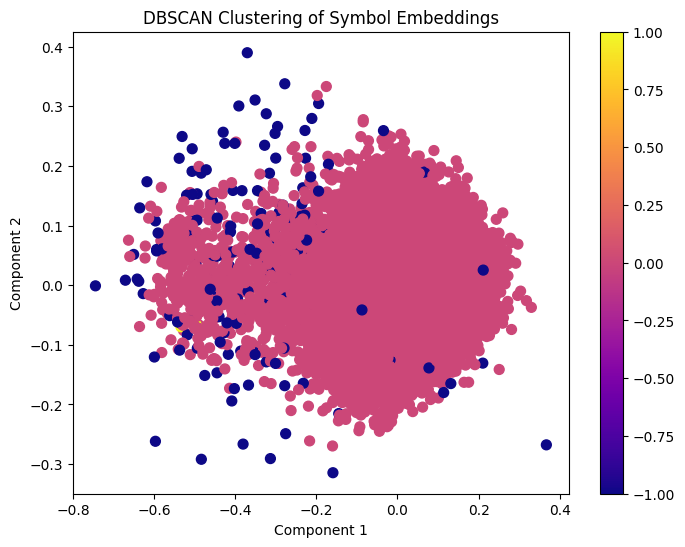

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='plasma', s=50)
plt.colorbar()
plt.title('DBSCAN Clustering of Symbol Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

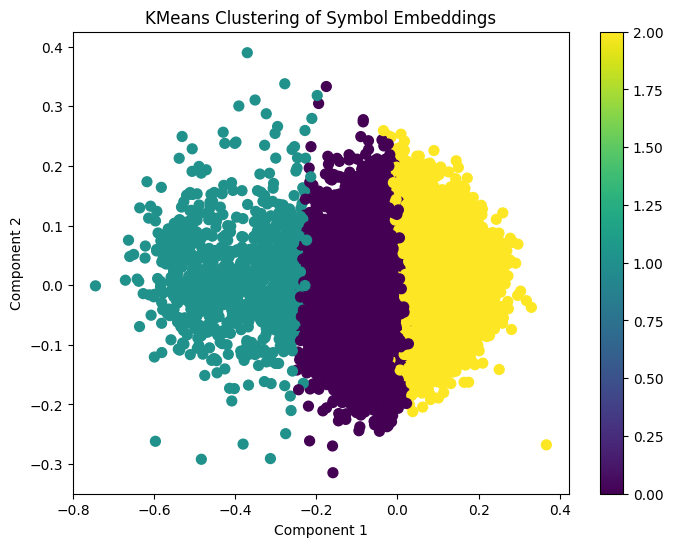

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=k_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('KMeans Clustering of Symbol Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

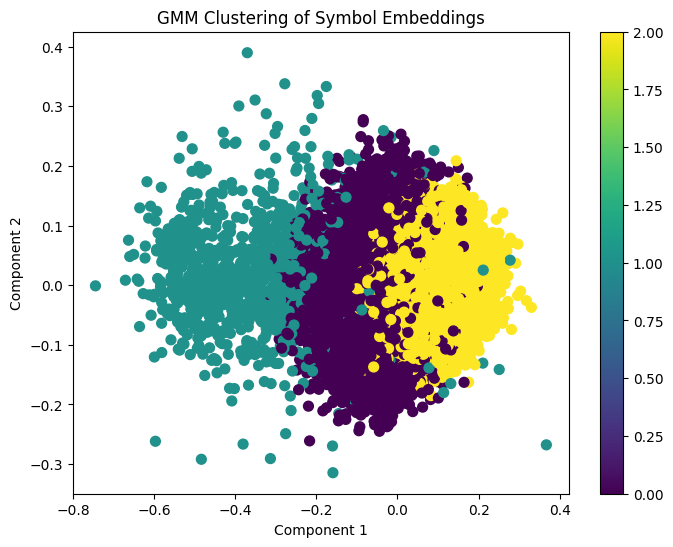

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=gmm_labels, cmap='viridis', s=50)
plt.colorbar()
plt.title('GMM Clustering of Symbol Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()